In [1]:
import os
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as L
from IPython.display import clear_output
#ENV Stuff
from rocket import Rocket
import utils

%matplotlib inline

2024-06-09 12:38:52.747565: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 12:38:52.747592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 12:38:52.748430: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-09 12:38:52.753103: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 12:38:53.367519: W tensorflow/compiler/tf2

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-06-09 12:38:54.039363: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-09 12:38:54.066315: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-09 12:38:54.066465: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Environment Setup

#### We are using Zhengxia Zou, Rocket-recycling with Reinforcement Learning, 2021

#### Repo Link: https://github.com/jiupinjia/rocket-recycling

We will be focusing on the landing problem with rockets



In [3]:
task = 'hover'
num_steps = 800 #Environment steps
env = Rocket(task=task, max_steps=num_steps)
obs_N = env.state_dims #Observations are position, speed, angle, angle velocity, nozzle angle, and the simulation time
act_N = env.action_dims #Actions are 3 thrust values in 3 directions

## Agent Setup

#### We wrote our own PPO-CLIP agent in Tensorflow 2
Actor            |  Critic
:-------------------------:|:-------------------------:
<img src="actor.png" alt="actor" width="200"/>  |  <img src="critic.png" alt="critic" width="200"/>

### Overall algorithm
* Initialize actor(policy), critic networks
* Collect trajectory(t=0 to T) in TRAJ
    * a = sample($\pi_{\theta_k}(a|s)$)
    * s', r, d = env.step(a)
    * logprob = $log(\pi_{\theta_k}(a|s)))$
* Calculate Advantage A using Generalized Advantage Estimation
* Calculate Reward-to-go RTG
* Update Actor
    * Get $log(\pi_\theta(a|s))$ using TRAJ
    * Calculate Diff: $log(\pi_\theta(a|s))-log(\pi_{\theta_k}(a|s))$
    * Calculate Ratio: exp(diff)
    * Calculate Loss: $\mathbb{E}_t$[min(Ratio\*A, clip(Ratio, 1-$\epsilon$, 1+$\epsilon$)\*A)]
    * Perform gradient descent on -Loss
* Update Critic
    * Get $V(s)$ using critic
    * Calculate Diff: $V(s)-RTG$
    * Calculate Loss: MSE(Diff)
    * Perform gradient descent on Loss

In [9]:
def createActor(obs_N, act_N):
    """
    Create Actor Model: Pi(a|s)
    inp->fc1->relu->fc2->relu->fc3->softmax out
    """
    inp = keras.Input(shape=obs_N, name='obs_input')
    x = L.Dense(64, kernel_initializer='he_uniform', activation='relu', name='fc1')(inp)
    x = L.Dense(32, kernel_initializer='he_uniform', activation='relu', name='fc2')(x)
    out = L.Dense(act_N, kernel_initializer='he_uniform', activation='softmax', name='fc3')(x)
    model = keras.Model(inputs=inp, outputs=out, name='actor')
    return model

def createCritic(obs_N):
    """
    Create Critic Model: V(s)
    inp->fc1->relu->fc2->relu->fc3->linear out
    """
    inp = keras.Input(shape=obs_N, name='obs_input')
    x = L.Dense(64, kernel_initializer='he_uniform', activation='relu', name='fc1')(inp)
    x = L.Dense(32, kernel_initializer='he_uniform', activation='relu', name='fc2')(x)
    out = L.Dense(1, kernel_initializer='he_uniform', name='fc3')(x)
    model = keras.Model(inputs=inp, outputs=out, name='critic')
    return model

class PPOClipAgent:
    def __init__(self, obs_N, act_N, actor_lr=1e-3, critic_lr=1e-3, gamma=0.9, clip=0.2, lmbda=0.95, entropy=1e-3, summary=None):
        #Agent parameters
        self.obs_N = obs_N
        self.act_N = act_N
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.gamma = gamma
        #Networks
        self.actor = createActor(obs_N, act_N)
        self.critic = createCritic(obs_N)
        #Optimizers
        self.actor_optimizer = keras.optimizers.Adam(learning_rate=actor_lr, clipvalue=1)
        self.critic_optimizer = keras.optimizers.Adam(learning_rate=critic_lr, clipvalue=1)
        #PPO specifics
        self.clip = clip
        self.lmbda = lmbda
        self.entropy = entropy

    def get_action(self, obs):
        """
        Return a discrete action from actor's softmax distribution
        """
        action_probs = self.actor(np.atleast_2d(obs))
        action = np.random.choice(np.arange(self.act_N), p=action_probs.numpy().flatten())
        return action, action_probs

    def get_gae_and_rtg(self, s, r, next_s, done, lengths):
        """
        Use generalized advantage estimation of the current batch of samples
        Also calculate the rewards to go, which is nothing but sum of discounted rewards from current state
        """
        #Current critic estimate of V(s)
        v_vals_s = self.critic(np.atleast_2d(s)).numpy()
        #Current critic estimate of V(s')
        #Please note this is essentially shifted i.e. s'(t)=s(t+1), but using it here to make implementation easy
        v_vals_next_s = self.critic(np.atleast_2d(next_s)).numpy()
        adv_full = np.zeros(len(r))
        rtg_full = np.zeros(len(r))
        #Buffer
        start_id = 0
        for lens in lengths:
            T = start_id+lens
            advantage = np.zeros(lens+1)
            rewards_to_go = np.zeros(lens+1)
            #td_T calculation
            td_err = r[T] + self.gamma*v_vals_next_s[T]*(1-done[T]) - v_vals_s[T]
            #r_T calculation
            rewards_to_go[-1] = r[T]*(1-done[T])
            for i in reversed(range(lens)):
                t = start_id+i
                #A_t = td_t + gamma*lambda*A_t+1
                advantage[i] = td_err + self.gamma*self.lmbda*(1-done[t])*advantage[i+1]
                #td_t-1 calculation
                td_err = r[t] + self.gamma*v_vals_next_s[t]*(1-done[t]) - v_vals_s[t]
                #Rewards to go
                rewards_to_go[i] = r[t] +  self.gamma*(rewards_to_go[i+1])*(1-done[t])
                
            #Final entries are 0 for adv and rtg, we don't need them
            adv_full[start_id:T] = advantage[:-1]
            rtg_full[start_id:T] = rewards_to_go[:-1]
            start_id = lens+1
        #Normalize advantage
#         advantage = (advantage-advantage.mean())/(advantage.std() + 1e-10)
        return adv_full, rtg_full

    def train_step(self, s, a, r, next_s, done, probs, lengths):
        """
        Train using experiences
        """
        #Get advantage and rtg values
        adv, rtg = self.get_gae_and_rtg(s, r, next_s, done, lengths)
        #Actor Update
        #We must ensure the original logprobs are not part of gradient calculation
        #Squeeze is needed to ensure same size as other logprobs
        logprobs = tf.squeeze(tf.math.log(probs)).numpy()
        actor_learnables = self.actor.trainable_variables
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(actor_learnables)
            curr_probs = self.actor(s)
            curr_logprobs = tf.math.log(curr_probs)
            diff_logprobs = curr_logprobs-logprobs
            ratio = tf.reduce_sum(tf.math.exp(diff_logprobs)*tf.one_hot(a, self.act_N), axis=1)
            surrogate1 = ratio*adv
            surrogate2 = tf.clip_by_value(ratio, 1-self.clip, 1+self.clip)*adv
            loss = tf.math.reduce_mean(tf.math.minimum(surrogate1, surrogate2))
            entropy = tf.math.reduce_mean(-curr_probs*curr_logprobs)
            actor_loss = -(loss - self.entropy*entropy)
            actor_grad = tape.gradient(actor_loss, actor_learnables)
        self.actor_optimizer.apply_gradients(zip(actor_grad, actor_learnables))
        #Critic Update
        critic_learnables = self.critic.trainable_variables
        with tf.GradientTape() as tape:
            #Squeeze was needed to make sure the sizes align
            v_vals_s = tf.squeeze(self.critic(s))
            #Critic loss is mean(r-v)^2
            critic_loss = tf.math.reduce_mean(tf.math.square(rtg - v_vals_s))
            critic_grad = tape.gradient(critic_loss, critic_learnables)
        self.critic_optimizer.apply_gradients(zip(critic_grad, critic_learnables))
        return actor_loss.numpy(), critic_loss.numpy()

In [10]:
agent = PPOClipAgent(obs_N, act_N, actor_lr=1e-3, critic_lr=1e-3, gamma=0.98, lmbda=0.97, entropy=1e-3)

## Training

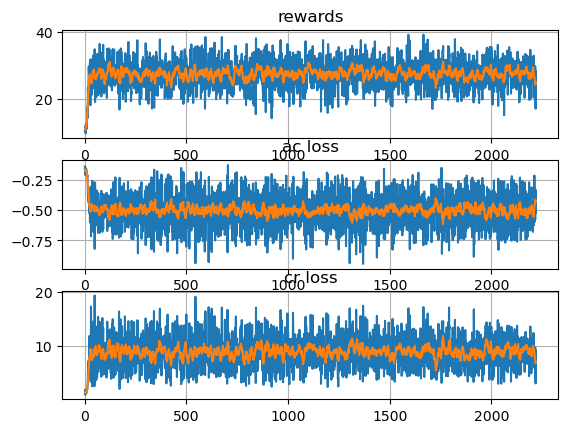

Iteration: 2219, Reward: 28.10096318687754


KeyboardInterrupt: 

In [11]:
num_iters = 10000 #Training iterations
num_epochs = 20 #Number of gradient steps
num_eps = 5
train_rewards = []
actor_losses = []
critic_losses = []
for it in range(num_iters):
    #Empty buffers to store episode
    s_buff = []
    a_buff = []
    r_buff = []
    next_s_buff = []
    done_buff = []
    probs_buff = []
    lengths_buff = []
    #Reminder that done will not be stored since we train only at the end of episode
    #Run environment num_eps times
    for ep in range(num_eps):
        #Reset env
        s = env.reset()
        for t in range(num_steps):
            #Get action
            a, a_prob = agent.get_action(s)
            #Step env forward
            next_s, r, done, info = env.step(a)
            #Extra step for done at end of env steps
            if t == num_steps-1:
                done = True
            #Batch collect samples
            s_buff.append(s)
            a_buff.append(a)
            r_buff.append(r)
            next_s_buff.append(next_s)
            done_buff.append(done)
            probs_buff.append(a_prob)
            #Set next state
            s = next_s
            #If complete break out of current episode
            if done:
                #This will be useful in advantage and rtg estimation
                lengths_buff.append(t)
                break
    #Ease of use with np arrays
    s_buff = np.array(s_buff)
    a_buff = np.array(a_buff)
    r_buff = np.array(r_buff)
    next_s_buff = np.array(next_s_buff)
    done_buff = np.array(done_buff)
    probs_buff = np.array(probs_buff)
    #We are training only at the end of episode
    a_loss_mean = 0
    c_loss_mean = 0
    for epoch in range(num_epochs):
        a_loss, c_loss = agent.train_step(s_buff, a_buff, r_buff, next_s_buff, done_buff, probs_buff, lengths_buff)
        a_loss_mean += a_loss
        c_loss_mean += c_loss
    #Utilities
    cum_rew = np.sum(r_buff)/num_eps
    train_rewards.append(cum_rew)
    actor_losses.append(a_loss_mean/num_epochs)
    critic_losses.append(c_loss_mean/num_epochs)
    clear_output(True)
    plt.subplot(3, 1, 1)
    plt.title("rewards")
    plt.plot(train_rewards)
    plt.plot(utils.moving_avg(train_rewards, N=10))
    plt.grid()
    plt.subplot(3, 1, 2)
    plt.title("ac loss")
    plt.plot(actor_losses)
    plt.plot(utils.moving_avg(actor_losses, N=10))
    plt.grid()
    plt.subplot(3, 1, 3)
    plt.title("cr loss")
    plt.plot(critic_losses)
    plt.plot(utils.moving_avg(critic_losses, N=10))
    plt.grid()
    plt.show()
    print('Iteration: {}, Reward: {}'.format(it, cum_rew))

## Evaluation

In [ ]:
s = env.reset()
cum_reward = 0
for t in range(num_steps):
    a, _ = agent.get_action(s)
    next_s, r, done, _= env.step(a)
    frame_0, frame_1 = env.render()
    cv2.imshow('fr', frame_0[:,:,::-1])
    cv2.waitKey(1)
    cv2.imshow('fr', frame_1[:,:,::-1])
    cv2.waitKey(1)
    if done:
        break
    if env.already_crash:
        break